# Post-Merger Halo Shape Analysis
Abhinav Vatsa – ASTR 400B

Inertia Tensor:
 [[3.55327985e+08 5.46408277e+06 3.52852561e+06]
 [5.46408277e+06 3.44289892e+08 2.20582841e+05]
 [3.52852561e+06 2.20582841e+05 3.57701657e+08]]
Global Axis Ratios — b/a: 0.991, c/a: 0.973
→ Based on axis ratios, the halo appears to be: **SPHERICAL**


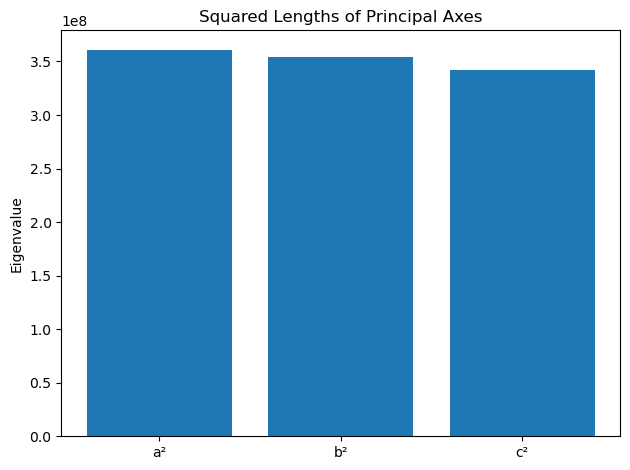

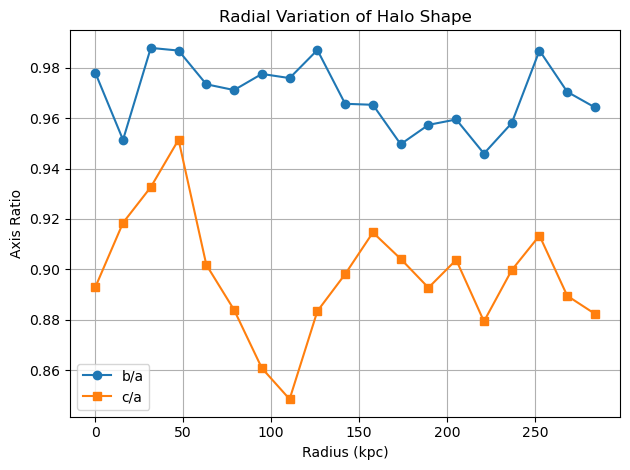

In [9]:
# Abhinav Vatsa – ASTR 400B
# Research Assignment 4: Determining the Shape of a Post-Merger Dark Matter Halo

import numpy as np
import matplotlib.pyplot as plt
from CenterOfMass2 import CenterOfMass  # Ensure this points to your COM class file

# ------------------------------------------------------------------------------
# Function: compute_inertia_tensor
# ------------------------------------------------------------------------------

def compute_inertia_tensor(positions, masses):
    """
    Construct the moment of inertia tensor for a 3D mass distribution.

    Parameters
    ----------
    positions : ndarray of shape (N, 3)
        Particle positions (x, y, z) in kpc, shifted to the halo's center of mass.

    masses : ndarray of shape (N,)
        Particle masses in 1e10 Msun.

    Returns
    -------
    I : ndarray of shape (3, 3)
        Moment of inertia tensor describing the halo geometry.
    """
    r_squared = np.sum(positions**2, axis=1)
    I = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            delta = 1.0 if i == j else 0.0
            I[i, j] = np.sum(masses * (r_squared * delta - positions[:, i] * positions[:, j]))
    return I

# ------------------------------------------------------------------------------
# Function: compute_axis_ratios
# ------------------------------------------------------------------------------

def compute_axis_ratios(inertia_tensor):
    """
    Compute axis ratios from the eigenvalues of the inertia tensor.

    Parameters
    ----------
    inertia_tensor : ndarray of shape (3, 3)
        Moment of inertia tensor.

    Returns
    -------
    b_to_a : float
        Intermediate-to-major axis ratio (b/a).

    c_to_a : float
        Minor-to-major axis ratio (c/a).

    eigvals : ndarray
        Sorted eigenvalues (a² ≥ b² ≥ c²), proportional to squared axis lengths.
    """
    eigvals, _ = np.linalg.eigh(inertia_tensor)
    eigvals = np.sort(eigvals)[::-1]
    return np.sqrt(eigvals[1]/eigvals[0]), np.sqrt(eigvals[2]/eigvals[0]), eigvals

# ------------------------------------------------------------------------------
# Function: radial_shell_axis_ratios
# ------------------------------------------------------------------------------

def radial_shell_axis_ratios(positions, masses, r_bins):
    """
    Measure how the shape of the halo changes with radius.

    Parameters
    ----------
    positions : ndarray of shape (N, 3)
        Particle positions (relative to COM) in kpc.

    masses : ndarray of shape (N,)
        Particle masses.

    r_bins : ndarray
        Array of radial bin edges (kpc) for analysis.

    Returns
    -------
    ba_list : list of float
        List of intermediate-to-major axis ratios (b/a) for each shell.

    ca_list : list of float
        List of minor-to-major axis ratios (c/a) for each shell.
    """
    ba_list, ca_list = [], []
    radii = np.linalg.norm(positions, axis=1)

    for i in range(len(r_bins) - 1):
        r1, r2 = r_bins[i], r_bins[i + 1]
        mask = (radii >= r1) & (radii < r2)
        if np.sum(mask) < 20:
            ba_list.append(np.nan)
            ca_list.append(np.nan)
            continue
        I_shell = compute_inertia_tensor(positions[mask], masses[mask])
        ba, ca, _ = compute_axis_ratios(I_shell)
        ba_list.append(ba)
        ca_list.append(ca)

    return ba_list, ca_list

# ------------------------------------------------------------------------------
# Load dark matter particle data from the two merging halos
# ------------------------------------------------------------------------------

# Load particle type 1 (dark matter) from each galaxy
MW = CenterOfMass("MW_445.txt", 1)
M31 = CenterOfMass("M31_445.txt", 1)

# Concatenate positions and masses from both halos
x = np.concatenate((MW.x, M31.x))
y = np.concatenate((MW.y, M31.y))
z = np.concatenate((MW.z, M31.z))
m = np.concatenate((MW.m, M31.m))

positions = np.vstack((x, y, z)).T
masses = m

# Shift everything to the combined center of mass frame
x_com, y_com, z_com = MW.COMdefine(x, y, z, m)
com = np.array([x_com, y_com, z_com])
positions -= com

# ------------------------------------------------------------------------------
# Compute the global shape of the halo
# ------------------------------------------------------------------------------

I_tensor = compute_inertia_tensor(positions, masses)
b_to_a, c_to_a, eigvals = compute_axis_ratios(I_tensor)

print("Inertia Tensor:\n", I_tensor)
print(f"Global Axis Ratios — b/a: {b_to_a:.3f}, c/a: {c_to_a:.3f}")

# Classify the shape based on axis ratios
if np.isclose(b_to_a, 1.0, atol=0.05) and np.isclose(c_to_a, 1.0, atol=0.05):
    shape = "spherical"
elif np.isclose(b_to_a, c_to_a, atol=0.05):
    shape = "prolate" if c_to_a < 1.0 else "oblate"
else:
    shape = "triaxial"

print(f"→ Based on axis ratios, the halo appears to be: **{shape.upper()}**")

# ------------------------------------------------------------------------------
# Visualize eigenvalues (global principal axis lengths)
# ------------------------------------------------------------------------------

plt.figure()
plt.bar(['a²', 'b²', 'c²'], eigvals)
plt.ylabel("Eigenvalue")
plt.title("Squared Lengths of Principal Axes")
plt.tight_layout()
plt.savefig("inertia_eigenvalues.png", dpi=300)

# ------------------------------------------------------------------------------
# Measure and plot the radial variation in shape
# ------------------------------------------------------------------------------

radii_bins = np.linspace(0, 300, 20)
ba_profile, ca_profile = radial_shell_axis_ratios(positions, masses, radii_bins)

plt.figure()
plt.plot(radii_bins[:-1], ba_profile, label="b/a", marker='o')
plt.plot(radii_bins[:-1], ca_profile, label="c/a", marker='s')
plt.xlabel("Radius (kpc)")
plt.ylabel("Axis Ratio")
plt.title("Radial Variation of Halo Shape")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("radial_axis_ratios.png", dpi=300)
# I am using snapshot 445 as the merger snapshot. I have to yet come up with code that tracks the time evolution of the merger and the consequent effects on the shape. 

In [ ]:
# ------------------------------------------------------------------------------
# Global Shape ≠ Local 
# ------------------------------------------------------------------------------
#
# The global shape classification spits out “spherical” — because
# both b/a and c/a are within ~5% of unity (0.991 and 0.973 respectively). And
# that’s not wrong mathematically when I average over the whole halo.
#
# The radial axis ratio plot shows that: c/a clearly dips to ~0.85
# between 100–150 kpc. That’s showing
# that the halo is not uniformly spherical. It’s flattened in the vertical
# direction at those radii, which means we’re looking at local triaxiality
# that the global average just smooths over.
#
# ------------------------------------------------------------------------------
